## Gaussian Mixture Models

Resources: 
- https://youtu.be/qMTuMa86NzU
- https://youtu.be/ZBLyXgjBx3Q

Reference: https://scikit-learn.org/stable/modules/mixture.html 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
import time
%matplotlib inline

import cv2

/home/oknaitik/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Part 1: Gaussian Mixture Models

We'll attempt to solve the task of background subtraction using Gaussian Mixture Models. Before that, we will implement the Gaussian Mixture Model algorithm from scratch.

In [2]:
class GMM(object):
    def __init__(self, n_components=1, tol=1e-3, max_iter=100):
        """
        n_components: The number of mixture components.
        tol: The convergence threshold
        """
        self.weights = None
        self.means = None
        self.covars = None
        self.n_comp = n_components
        self.tol = tol
        self.max_iter = max_iter
        # self.expectations = []
        self.total_iter = max_iter

    def initialize_params(self, X):
        """
        X : A collection of `N` training data points, each with dimension `d`.
        """
        N, d = X.shape
        # randomly pick K pixels
        self.means = X[np.random.choice(N, self.n_comp, replace=False)]

        # initialize covariance matrix as identity
        self.covars = np.array([np.eye(d)] * self.n_comp)

        # assign same values to all coeff
        self.weights = np.ones(self.n_comp) / self.n_comp
    
    def E_step(self, X):
        """
        Find the Expectation of the log-likelihood evaluated using the current estimate for the parameters.
        """
        N = X.shape[0]
        K = self.n_comp
        resp = np.zeros((N, K)) # resp[n][k]: probability of that nth point belongs to kth gaussian

        for k in range(K):
            resp[:, k] = self.weights[k] * multivariate_normal.pdf(X, mean=self.means[k], cov=self.covars[k])

        # normalize responsibilities
        resp_sum = np.sum(resp, axis=1) # denominator is same for all columns given a row
        resp /= resp_sum[:, np.newaxis]
        
        # expectation
        # E = 0
        # epsilon = 1e-8
        # for n  in range(N):
        #     for k in range(K):
        #         E += resp[n, k] * np.log(epsilon + self.weights[k] * multivariate_normal.pdf(X[n], mean=self.means[k], cov=self.covars[k]))

        return resp

    def M_step(self, X, resp):
        """
        Updates parameters maximizing the expected log-likelihood found on the E step.
        """
        N, d = X.shape
        K = self.n_comp

        self.weights = np.sum(resp, axis=0) / N # sum over N
        
        regularization_term = 1e-8
        # update means and covariances
        for k in range(K):
            # all updates should happen simultaneously
            diff = X - self.means[k]
            self.means[k] = np.sum(X * resp[:, k][:, np.newaxis], axis=0) / np.sum(resp[:, k])
            self.covars[k] = np.dot((resp[:, k][:, np.newaxis] * diff).T, diff) / np.sum(resp[:, k])
            self.covars[k] += np.eye(d) * regularization_term # add regularization term to counter non-invertibility
    
    def fit(self, X, y=None):
        """
        Fit the parameters of the GMM on some training data.
        """
        self.initialize_params(X)
        
        for i in range(self.max_iter):
            resp = self.E_step(X)
            self.M_step(X, resp)
            # self.expectations.append(E)

            # if i >= 1 and abs(E - self.expectations[i-1]) < self.tol:
            #     self.total_iter = i+1
            #     break
            
    """
    def plot_expectation(self):
        plt.plot(range(self.total_iter), self.expectations, 'o-')
        plt.xlabel('Iteration')
        plt.ylabel('Expectation')
        plt.title('Log-likelihood Expectation Plot')
        plt.grid('true')
        plt.show()
    """
    
    def predict(self, X):
        """
        Predict the labels for the data samples in X using trained model.
        """
        resp = self.E_step(X)
        return np.argmax(resp, axis=1) # for each data point, get the most probable Gaussian index

### Part 2: Background Subtraction

![traffic](./videos/traffic.gif)

We are supposed to extract the background image from a given set of training frames, and use the extracted background to display foreground objects in the test frames by subtracting that background image and then thresholding it accordingly.

We are going to try different baselines to extract background from low resolution camera footage:

1. Frame Averaging:
    - Just take the average of every training frame, which gives us an approximate background image.
    
2. GMM Per Pixel:
    - We will maintain per pixel GMMs of 2 components, and then fit these GMMs considering every training from for its corresponding pixel.
    - And then use these GMMs to predict the pixel labels for every subsequent frame.
    - Most of the time, the Gaussian with the higher weight corresponds to the background.
    - We can implement this in a simpler way but with worse prediction results, you can extract a mean background image similar to the first baseline above.
    - To extract the Mean background image, we can assign values of the Means corresponding to the highest weighted Gaussian for each pixel.
    - This method is much simpler to implement but, this could give worse results.

#### Extracting Frames from videos

In [3]:
source_folder = 'videos'
video = 'traffic.gif'

source_path = f'./{source_folder}/{video}'

In [4]:
data_folder = 'frames'

frames_path = f"./{data_folder}/{video.rsplit('.', 1)[0]}"

In [5]:
%%capture

!mkdir -p {frames_path} > /dev/null ;

In [6]:
%%capture

!ffmpeg -i {source_path} {frames_path}/'frame_%04d.png' > /dev/null ;

#### Loading Frames

In [7]:
import glob

frames = []
for file_path in sorted(glob.glob(f'{frames_path}/*.png', recursive = False)):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.asarray(img, dtype=np.float64)
    img /= 255.0
    
    frames.append(img)
frames = np.asarray(frames, dtype=np.float64)

In [8]:
frames.shape

(80, 120, 160, 3)

#### Splitting the data

In [9]:
from sklearn.model_selection import train_test_split

print(f'frame: {frames.shape}')

train_frames, test_frames = train_test_split(frames, train_size=0.6, shuffle=False) # Do Not Shuffle!

print(f'train_frames: {train_frames.shape}')
print(f'test_frames: {test_frames.shape}')

frame: (80, 120, 160, 3)
train_frames: (48, 120, 160, 3)
test_frames: (32, 120, 160, 3)


#### Frame Averaging

Extract Background Frame from the training data and display it.

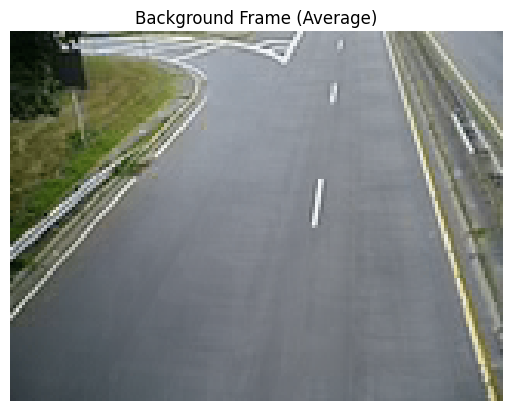

In [10]:
# your code here
background_frame_avg = np.mean(frames, axis=0)

plt.imshow(background_frame_avg)
plt.title('Background Frame (Average)')
plt.axis('off') 
plt.show()

#### GMMs per pixel

Create Set of GMMs for every pixel and fit them considering every training frame

In [11]:
# your code here
gmm_models = []
for i in range(train_frames.shape[1]):
    for j in range(train_frames.shape[2]):
        pixel_data = train_frames[:, i, j, :]  # extract pixel data across all frames
        gmm = GMM(n_components=2) 
        gmm.fit(pixel_data) 
        gmm_models.append(gmm)  # store the trained GMM

#### Extract Background Frame from the Trained Model

In [13]:
# your code here
background_frame_gmm = np.zeros(frames.shape[1:4])

for i in range(train_frames.shape[1]):
    for j in range(train_frames.shape[2]):
        pixel_data = train_frames[:, i, j, :]  
        
        gmm = gmm_models[i * train_frames.shape[2] + j]  # retrieve trained gmm
        background_component = np.argmax(gmm.weights) # index of Gaussian with max weight
        background_frame_gmm[i, j] = gmm.means[background_component] # get the mean vector of bg Gaussian component 

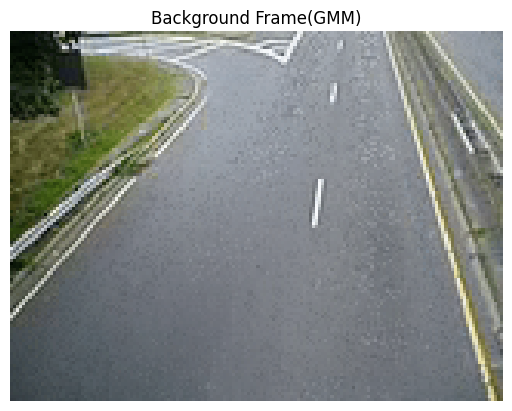

In [14]:
plt.imshow(background_frame_gmm)
plt.title('Background Frame(GMM)')
plt.axis('off') 
plt.show()

### Outputs


In [15]:
# helper functions
def display_frames(frames, fps=10.0):
    """
    Display the frames as a video.
    """
    eps = 0.0001
    
    wait_time = int(1000 // fps)
    
    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)
        
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        
        cv2.imshow("video", frame)
        k = cv2.waitKey(wait_time)

        if k == ord('q'):
            print("Quitting...")
            break
    
    cv2.destroyAllWindows()


def save_frames(frames, fps=10.0, output_path='./results', file_name='temp'):
    """
    Save the frames as a video.
    """
    eps = 0.0001
    
    frame_rate = float(fps)
    frame_size = (int(frames[0].shape[1]), int(frames[0].shape[0]))
    wait_time = int(1000 // fps)
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    
    save_path = os.path.join(output_path, f"{file_name.rsplit('.', 1)[0]}.mp4")
    
    vid_wrt = cv2.VideoWriter(save_path, fourcc, frame_rate, frame_size)

    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)
        
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        
        cv2.imshow('frame',frame)
        if cv2.waitKey(wait_time) & 0xFF == ord('q'):
            break
        
        vid_wrt.write(frame)

        
    vid_wrt.release()
    cv2.destroyAllWindows()

In [16]:
# subtract background and threshold
def extract_foreground(frames, background_frame, threshold=20):
    foreground_frames = []

    for frame in frames:        
        # subtract background frame from the frame
        diff_frame = cv2.absdiff(frame, background_frame)
        
        # apply thresholding to identify foreground objects
        _, thresh_frame = cv2.threshold(diff_frame, threshold, 255, cv2.THRESH_BINARY)
        foreground_frames.append(diff_frame)       
    return foreground_frames

#### Frame Averaging

In [17]:
# your output here
foreground_frames_avg = extract_foreground(test_frames, background_frame_avg)
display_frames(foreground_frames_avg)
save_frames(foreground_frames_avg, output_path='./results', file_name='foreground_video_avg')

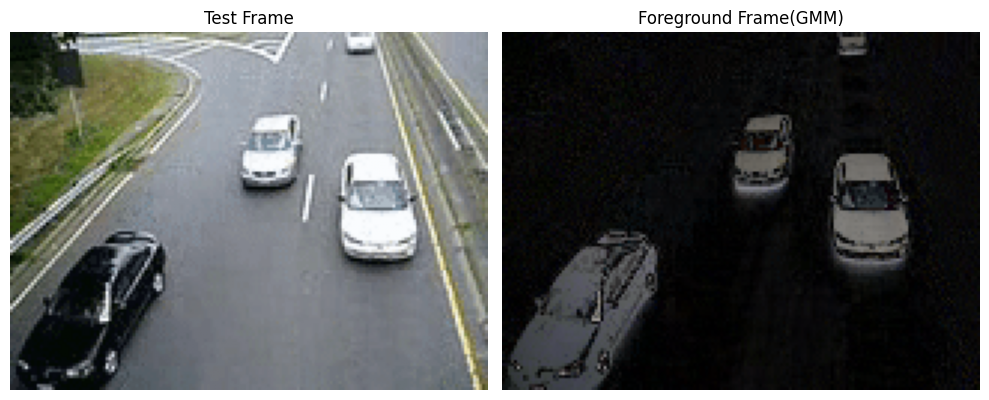

In [18]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_frames[0])
plt.title('Test Frame')
plt.axis('off') 

plt.subplot(1, 2, 2)
plt.imshow(foreground_frames_avg[0])
plt.title('Foreground Frame(GMM)')
plt.axis('off')

plt.tight_layout()
plt.show()

#### GMMs per pixel

In [19]:
foreground_frames_gmm = extract_foreground(test_frames, background_frame_gmm)
display_frames(foreground_frames_gmm)
save_frames(foreground_frames_gmm, output_path='./results', file_name='foreground_video_gmm')

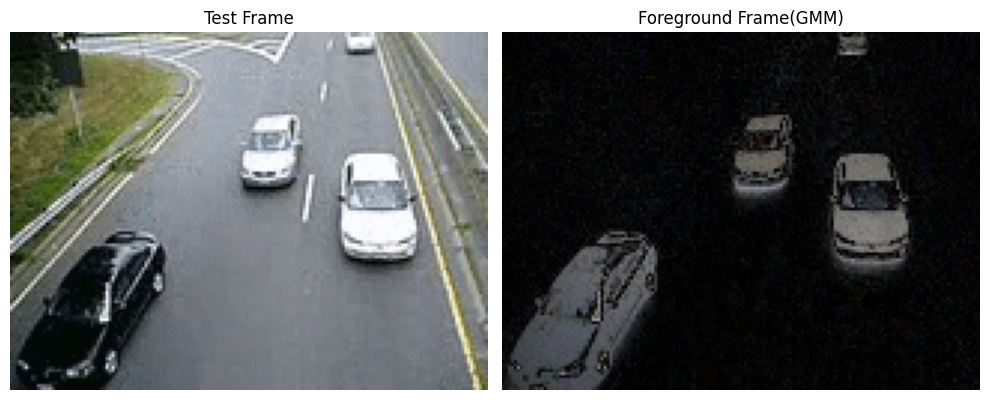

In [20]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_frames[0])
plt.title('Test Frame')
plt.axis('off') 

plt.subplot(1, 2, 2)
plt.imshow(foreground_frames_gmm[0])
plt.title('Foreground Frame(GMM)')
plt.axis('off')

plt.tight_layout()
plt.show()